### This notebook combines the different modalities using a simple NN which takes the probabilities produced by each modality as input.

In [37]:
import os
import numpy as np
import pandas as pd
from collections import Counter
import json
import numpy as np
import itertools as it
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_fscore_support

In [47]:
def load_label(partition=True, verbose=False):
    """load the labels (age, gender, YMRS)
    """
    # para partition: whether to partition labels into train/dev sets
    # para verbose: whether or not to output more statistical results
    # return: YMRS score and Mania level for train/dev set
    # return: YMRS score and Mania level for all dataset (if not partition)
    label = pd.read_csv("/home/ceccarelli/Work/Bipolar/labels_metadata.csv")
    id_list = label['SubjectID'].tolist()

    id_set = set()
    age_list = list()
    for id in id_list:
        id_set.add(id)
        age_list.extend(label[label.SubjectID == id]['Age'].tolist())

    gender_list = list()
    for sub in id_set:
        gender_list.append(sub[:1])
        if verbose:
            print("%s subject have %d instances" % (sub, id_list.count(sub)))
    
    classes_stats = Counter(label['ManiaLevel'].tolist())

    if verbose:
        print("All subjects", len(id_set))
        print("Male subjects ", gender_list.count('M'))
        print("Female subjects", gender_list.count('F'))
        print("Age range (%d, %d), Age median %d" % (min(age_list), max(age_list), statistics.median(age_list)))
        print("Class distribution stats", classes_stats)

    ymrs_score = pd.concat([label.iloc[:, 0], label.iloc[:, 4]], axis=1)
    mania_level = pd.concat([label.iloc[:, 0], label.iloc[:, 5]], axis=1)
    if partition:
        ymrs_dev = ymrs_score.iloc[:60, :]
        ymrs_train = ymrs_score.iloc[60:, :]
        level_dev = mania_level.iloc[:60, :]
        level_train = mania_level.iloc[60:, :]
        return ymrs_dev.values[:, 1], ymrs_train.values[:, 1], level_dev.values[:, 1], level_train.values[:, 1]
    else:
        return ymrs_score, mania_level, 0, 0

In [48]:
class RandomForest():
   
    def __init__(self, feature_name, X_train, y_train, X_dev, y_dev, line):
        self.config = json.load(open('../model.json', 'r'))
        self.model_name = 'RF_CV'
        self.feature_name = feature_name
        self.X_train = X_train
        self.X_dev = X_dev
        self.y_train = y_train
        self.y_dev = y_dev
        self.parameters = dict()
        self.parameters['n_estimators'] = None
        self.parameters['max_features'] = None
        self.parameters['max_depth'] = None
        self.parameters['criterion'] = None
        self.model = None
        self.line = line

    def run(self):

        filename = os.path.join(self.line, '%s_%s_params.json' % (self.model_name, self.feature_name))
        print ("Reading %s for configuration" %filename)
        if os.path.isfile(filename):
            self.parameters = json.load(open(filename, 'r'))
        
            # build RF model
            # using saved parameters
            self.model = RandomForestClassifier(
                n_estimators=self.parameters['n_estimators'], 
                max_features=self.parameters['max_features'], 
                max_depth=self.parameters['max_depth'], 
                criterion=self.parameters['criterion'], 
                verbose=0, n_jobs=-1,
                class_weight="balanced")
            self.train()
        else:
            print ('Model not trained -- Parameter file not found!')

    def train(self):
        
        self.model.fit(self.X_train, self.y_train)

    def evaluate(self):
        
        print("\nevaluating the Random Forest Classifier ...")
        y_pred_train = self.model.predict(self.X_train)
        y_pred_dev = self.model.predict(self.X_dev)

        y_pred_train_prob = self.model.predict_proba(self.X_train)
        y_pred_dev_prob = self.model.predict_proba(self.X_dev)
        
        return y_pred_train, y_pred_dev, y_pred_train_prob, y_pred_dev_prob


In [54]:
# choose path to the best models for each modality
# and produce probabilities 

video_path = "../FINAL_RESULTS_30/Landmarks_timesteps30_dimensionsBiLstm41/"
video_train = np.load(os.path.join(video_path, 'X_train_tree_32_100.npy'))
video_dev = np.load(os.path.join(video_path, 'X_dev_tree_32_100.npy'))

video_path1 = "../FINAL_RESULTS_60/Action_timesteps60_dimensionsBiLstm10/"
video_train1 = np.load(os.path.join(video_path1, 'X_train_tree_32_100.npy'))
video_dev1 = np.load(os.path.join(video_path1, 'X_dev_tree_32_100.npy'))

video_path2 = "../FINAL_RESULTS_30/Gaze_timesteps30_dimensionsBiLstm1/"
video_train2 = np.load(os.path.join(video_path2, 'X_train_tree_32_50.npy'))
video_dev2 = np.load(os.path.join(video_path2, 'X_dev_tree_32_50.npy'))

video_path3 = "../FINAL_RESULTS_10/Pose_timesteps10_dimensionsBiLstm1/"
video_train3 = np.load(os.path.join(video_path3, 'X_train_tree_32_50.npy'))
video_dev3 = np.load(os.path.join(video_path3, 'X_dev_tree_32_50.npy'))

audio_path = "../FINAL_RESULTS_60/MFCC_timesteps60_dimensionsBiLstm35/"
audio_train = np.load(os.path.join(audio_path, 'X_train_tree_32_100.npy'))
audio_dev = np.load(os.path.join(audio_path, 'X_dev_tree_32_100.npy'))

audioE_path = "../FINAL_RESULTS_10/eGeMAPS_timesteps10_dimensionsBiLstm21/"
audioE_train = np.load(os.path.join(audioE_path, 'X_train_tree_16_100.npy'))
audioE_dev = np.load(os.path.join(audioE_path, 'X_dev_tree_16_100.npy'))

text_path = "../FINAL_RESULTS_TEXT/PV-COMBINED-AV/50_10_10_0"
text_train = np.load(os.path.join(text_path, 'vectors_train.npy'))
text_dev = np.load(os.path.join(text_path, 'vectors_dev.npy'))


_, _ , y_dev, y_train = load_label()

random_forest = RandomForest("Landmarks_32_100", video_train, list(y_train), video_dev, list(y_dev),"../FINAL_RESULTS_30/Landmarks_timesteps30_dimensionsBiLstm41/")
random_forest.run()
y_pred_train_video, y_pred_dev_video, y_pred_train_video_p, y_pred_dev_video_p = random_forest.evaluate()

random_forest = RandomForest("Action_32_100", video_train1, list(y_train), video_dev1, list(y_dev), "../FINAL_RESULTS_60/Action_timesteps60_dimensionsBiLstm10/")
random_forest.run()
y_pred_train_video1, y_pred_dev_video1, y_pred_train_video_p1, y_pred_dev_video_p1 = random_forest.evaluate()

random_forest = RandomForest("Gaze_32_50", video_train2, list(y_train), video_dev2, list(y_dev), "../FINAL_RESULTS_30/Gaze_timesteps30_dimensionsBiLstm1/")
random_forest.run()
y_pred_train_video2, y_pred_dev_video2, y_pred_train_video_p2, y_pred_dev_video_p2 = random_forest.evaluate()

random_forest = RandomForest("Pose_32_50", video_train3, list(y_train), video_dev3, list(y_dev), "../FINAL_RESULTS_10/Pose_timesteps10_dimensionsBiLstm1/")
random_forest.run()
y_pred_train_video3, y_pred_dev_video3, y_pred_train_video_p3, y_pred_dev_video_p3 = random_forest.evaluate()

random_forest = RandomForest("MFCC_32_100", audio_train, list(y_train), audio_dev, list(y_dev), "../FINAL_RESULTS_60/MFCC_timesteps60_dimensionsBiLstm35/")
random_forest.run()
y_pred_train_audio, y_pred_dev_audio, y_pred_train_audio_p, y_pred_dev_audio_p  = random_forest.evaluate()

random_forest = RandomForest("eGeMAPS_16_100", audioE_train, list(y_train), audioE_dev, list(y_dev), "../FINAL_RESULTS_10/eGeMAPS_timesteps10_dimensionsBiLstm21/")
random_forest.run()
y_pred_train_audioE, y_pred_dev_audioE, y_pred_train_audioE_p, y_pred_dev_audioE_p = random_forest.evaluate()

random_forest = RandomForest("TEXT_50_10_10_0", text_train, list(y_train), text_dev, list(y_dev), "../FINAL_RESULTS_TEXT/PV-COMBINED-AV/")
random_forest.run()
y_pred_train_text, y_pred_dev_text, y_pred_train_text_p, y_pred_dev_text_p = random_forest.evaluate()



Reading ../FINAL_RESULTS_30/Landmarks_timesteps30_dimensionsBiLstm41/RF_CV_Landmarks_32_100_params.json for configuration

evaluating the Random Forest Classifier ...
Reading ../FINAL_RESULTS_60/Action_timesteps60_dimensionsBiLstm10/RF_CV_Action_32_100_params.json for configuration

evaluating the Random Forest Classifier ...
Reading ../FINAL_RESULTS_30/Gaze_timesteps30_dimensionsBiLstm1/RF_CV_Gaze_32_50_params.json for configuration

evaluating the Random Forest Classifier ...
Reading ../FINAL_RESULTS_10/Pose_timesteps10_dimensionsBiLstm1/RF_CV_Pose_32_50_params.json for configuration

evaluating the Random Forest Classifier ...
Reading ../FINAL_RESULTS_60/MFCC_timesteps60_dimensionsBiLstm35/RF_CV_MFCC_32_100_params.json for configuration

evaluating the Random Forest Classifier ...
Reading ../FINAL_RESULTS_10/eGeMAPS_timesteps10_dimensionsBiLstm21/RF_CV_eGeMAPS_16_100_params.json for configuration

evaluating the Random Forest Classifier ...
Reading ../FINAL_RESULTS_TEXT/PV-COMBINED-

In [55]:
sets = ['landmarks', 'FAU', 'Gaze', 'Pose', 'MFCC', 'eGeMAPS', 'Text']

In [56]:
mean_voting = 0
max_voting = np.zeros((60,3))
x_train = list()
x_dev = list()

for i in range(len(sets)):
    if sets[i] == 'landmarks':
        mean_voting += y_pred_dev_video_p
        x_train.append(y_pred_train_video_p)
        x_dev.append(y_pred_dev_video_p)
        for i in range(len(y_pred_dev_video)):
            if (y_pred_dev_video[i]==1):
                max_voting[i][0] += 1
            elif (y_pred_dev_video[i]==2):
                max_voting[i][1] += 1
            else:
                max_voting[i][2] += 1
                
    elif sets[i] == 'FAU':
        mean_voting += y_pred_dev_video_p1
        x_train.append(y_pred_train_video_p1)
        x_dev.append(y_pred_dev_video_p1)
        for i in range(len(y_pred_dev_video1)):
            if (y_pred_dev_video1[i]==1):
                max_voting[i][0] += 1
            elif (y_pred_dev_video1[i]==2):
                max_voting[i][1] += 1
            else:
                max_voting[i][2] += 1
                
    elif sets[i] == 'Gaze':
        mean_voting += y_pred_dev_video_p2
        x_train.append(y_pred_train_video_p2)
        x_dev.append(y_pred_dev_video_p2)
        for i in range(len(y_pred_dev_video2)):
            if (y_pred_dev_video2[i]==1):
                max_voting[i][0] += 1
            elif (y_pred_dev_video2[i]==2):
                max_voting[i][1] += 1
            else:
                max_voting[i][2] += 1
                
    elif sets[i] == 'Pose':
        mean_voting += y_pred_dev_video_p3
        x_train.append(y_pred_train_video_p3)
        x_dev.append(y_pred_dev_video_p3)
        for i in range(len(y_pred_dev_video3)):
            if (y_pred_dev_video3[i]==1):
                max_voting[i][0] += 1
            elif (y_pred_dev_video3[i]==2):
                max_voting[i][1] += 1
            else:
                max_voting[i][2] += 1
        
    elif sets[i] == 'MFCC':
        mean_voting += y_pred_dev_audio_p
        x_train.append(y_pred_train_audio_p)
        x_dev.append(y_pred_dev_audio_p)
        for i in range(len(y_pred_dev_audio)):
            if (y_pred_dev_audio[i]==1):
                max_voting[i][0] += 1
            elif (y_pred_dev_audio[i]==2):
                max_voting[i][1] += 1
            else:
                max_voting[i][2] += 1
        
    elif sets[i] == 'eGeMAPS':
        mean_voting += y_pred_dev_audioE_p
        x_train.append(y_pred_train_audioE_p)
        x_dev.append(y_pred_dev_audioE_p)
        for i in range(len(y_pred_dev_audioE)):
            if (y_pred_dev_audioE[i]==1):
                max_voting[i][0] += 1
            elif (y_pred_dev_audioE[i]==2):
                max_voting[i][1] += 1
            else:
                max_voting[i][2] += 1
        
    elif sets[i] == 'Text':
        mean_voting += y_pred_dev_text_p
        x_train.append(y_pred_train_text_p)
        x_dev.append(y_pred_dev_text_p)
        if (y_pred_dev_text[i]==1):
                max_voting[i][0] += 1
        elif (y_pred_dev_text[i]==2):
                max_voting[i][1] += 1
        else:
                max_voting[i][2] += 1
        
mean_voting = mean_voting/len(sets)
f1 = np.argmax(mean_voting, axis=-1)+1
print ("Mean voting")
print ("------"*10)
precision, recall, fscore, _ = precision_recall_fscore_support(list(y_dev), f1, average='macro')
print("\naccuracy on development set: %.4f" % metrics.accuracy_score(f1, list(y_dev)))
print("\nprecision on dev set: %.4f" % precision)
print("\nrecall on dev set: %.4f" % recall)
print("\nfscore on dev set: %.4f" % fscore)
print ("------"*10)

print ("\n")

print ("Max voting")
f_pred1 = np.argmax(max_voting, axis=-1)+1
precision, recall, fscore, _ = precision_recall_fscore_support(list(y_dev), f_pred1, average='macro')
print("\naccuracy on development set: %.4f" % metrics.accuracy_score(f_pred1, list(y_dev)))
print("\nprecision on dev set: %.4f" % precision)
print("\nrecall on dev set: %.4f" % recall)
print("\nfscore on dev set: %.4f" % fscore)

x_train = np.hstack((x_train))
x_dev = np.hstack((x_dev))
x_dev.shape

Mean voting
------------------------------------------------------------

accuracy on development set: 0.8667

precision on dev set: 0.8984

recall on dev set: 0.8545

fscore on dev set: 0.8562
------------------------------------------------------------


Max voting

accuracy on development set: 0.8667

precision on dev set: 0.8722

recall on dev set: 0.8624

fscore on dev set: 0.8649


(60, 21)

In [ ]:
#save best prediction
#np.save("../RESULTS/Dev_video_predictions.npy",y_pred_dev_video_p)
#np.save("../RESULTS/Dev_audio_predictions.npy",y_pred_dev_audio_p)
#np.save("../RESULTS/Dev_audioE_predictions.npy",y_pred_dev_audioE_p)
#np.save("../RESULTS/Dev_text_predictions.npy",y_pred_dev_text_p)

#np.save("../RESULTS/Train_video_predictions.npy",y_pred_train_video_p)
#np.save("../RESULTS/Train_audio_predictions.npy",y_pred_train_audio_p)
#np.save("../RESULTS/Train_audioE_predictions.npy",y_pred_train_audioE_p)
#np.save("../RESULTS/Train_text_predictions.npy",y_pred_train_text_p)

#load 
#y_pred_dev_video_p = np.load("../RESULTS/Dev_video_predictions.npy")
#y_pred_dev_audio_p = np.load("../RESULTS/Dev_audio_predictions.npy")
#y_pred_dev_audioE_p = np.load("../RESULTS/Dev_audioE_predictions.npy")
#y_pred_dev_text_p = np.load("../RESULTS/Dev_text_predictions.npy")

#y_pred_train_video_p = np.load("../RESULTS/Train_video_predictions.npy")
#y_pred_train_audio_p = np.load("../RESULTS/Train_audio_predictions.npy")
#y_pred_train_audioE_p = np.load("../RESULTS/Train_audioE_predictions.npy")
#y_pred_train_text_p = np.load("../RESULTS/Train_text_predictions.npy")

In [57]:
#ADAPTIVE 
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.utils import to_categorical
from sklearn.metrics import precision_recall_fscore_support
from sklearn import metrics
text_yes = False

print (x_train.shape)
print (x_dev.shape)
model = Sequential()
model.add(Dense(4, input_dim=x_dev.shape[1], activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

y_train_keras = to_categorical(y_train-1)
y_dev_keras = to_categorical(y_dev-1)
save_dir = "../FINAL_RESULTS_FUSION/"
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

(104, 21)
(60, 21)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 4)                 88        
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 15        
Total params: 103
Trainable params: 103
Non-trainable params: 0
_________________________________________________________________


In [58]:
csv_logger = CSVLogger(os.path.join(save_dir, "logger.csv"))
checkpoint = ModelCheckpoint(os.path.join(save_dir, "weights-improvement-{epoch:02d}-{loss:.2f}.hdf5"), 
                                 monitor='val_acc', 
                                 verbose=1, save_best_only=True, mode='max')
callbacks_list = [csv_logger, checkpoint]


hist = model.fit(x_train, y_train_keras, epochs=500, batch_size=2,
                 validation_data = (x_dev, y_dev_keras), callbacks=callbacks_list)



Train on 104 samples, validate on 60 samples
Epoch 1/500
104/104 [==============================] - 0s 4ms/step - loss: 0.5794 - acc: 0.6667 - val_loss: 0.6132 - val_acc: 0.6667

Epoch 00001: val_acc improved from -inf to 0.66667, saving model to ../FINAL_RESULTS_FUSION/weights-improvement-01-0.58.hdf5
Epoch 2/500
104/104 [==============================] - 0s 612us/step - loss: 0.4980 - acc: 0.7436 - val_loss: 0.5845 - val_acc: 0.6722

Epoch 00002: val_acc improved from 0.66667 to 0.67222, saving model to ../FINAL_RESULTS_FUSION/weights-improvement-02-0.50.hdf5
Epoch 3/500
104/104 [==============================] - 0s 584us/step - loss: 0.4335 - acc: 0.8686 - val_loss: 0.5807 - val_acc: 0.7167

Epoch 00003: val_acc improved from 0.67222 to 0.71667, saving model to ../FINAL_RESULTS_FUSION/weights-improvement-03-0.43.hdf5
Epoch 4/500
104/104 [==============================] - 0s 580us/step - loss: 0.3715 - acc: 0.8686 - val_loss: 0.5794 - val_acc: 0.7278

Epoch 00004: val_acc improved fr

104/104 [==============================] - 0s 788us/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.3832 - val_acc: 0.8278

Epoch 00038: val_acc did not improve from 0.83333
Epoch 39/500
104/104 [==============================] - 0s 629us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.3818 - val_acc: 0.8333

Epoch 00039: val_acc did not improve from 0.83333
Epoch 40/500
104/104 [==============================] - 0s 631us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.3796 - val_acc: 0.8333

Epoch 00040: val_acc did not improve from 0.83333
Epoch 41/500
104/104 [==============================] - 0s 618us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.3787 - val_acc: 0.8333

Epoch 00041: val_acc did not improve from 0.83333
Epoch 42/500
104/104 [==============================] - 0s 623us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.3766 - val_acc: 0.8389

Epoch 00042: val_acc improved from 0.83333 to 0.83889, saving model to ../FINAL_RESULTS_FUSION/weights-improvement-42-0.00.hdf5


104/104 [==============================] - 0s 608us/step - loss: 1.0776e-04 - acc: 1.0000 - val_loss: 0.3128 - val_acc: 0.8889

Epoch 00120: val_acc did not improve from 0.88889
Epoch 121/500
104/104 [==============================] - 0s 614us/step - loss: 1.0439e-04 - acc: 1.0000 - val_loss: 0.3124 - val_acc: 0.8889

Epoch 00121: val_acc did not improve from 0.88889
Epoch 122/500
104/104 [==============================] - 0s 614us/step - loss: 1.0113e-04 - acc: 1.0000 - val_loss: 0.3118 - val_acc: 0.8889

Epoch 00122: val_acc did not improve from 0.88889
Epoch 123/500
104/104 [==============================] - 0s 601us/step - loss: 9.8021e-05 - acc: 1.0000 - val_loss: 0.3111 - val_acc: 0.8889

Epoch 00123: val_acc did not improve from 0.88889
Epoch 124/500
104/104 [==============================] - 0s 607us/step - loss: 9.4965e-05 - acc: 1.0000 - val_loss: 0.3108 - val_acc: 0.8889

Epoch 00124: val_acc did not improve from 0.88889
Epoch 125/500
104/104 [==============================]

104/104 [==============================] - 0s 732us/step - loss: 2.9922e-05 - acc: 1.0000 - val_loss: 0.2939 - val_acc: 0.8944

Epoch 00162: val_acc did not improve from 0.90000
Epoch 163/500
104/104 [==============================] - 0s 720us/step - loss: 2.9014e-05 - acc: 1.0000 - val_loss: 0.2935 - val_acc: 0.9000

Epoch 00163: val_acc did not improve from 0.90000
Epoch 164/500
104/104 [==============================] - 0s 864us/step - loss: 2.8178e-05 - acc: 1.0000 - val_loss: 0.2929 - val_acc: 0.9000

Epoch 00164: val_acc did not improve from 0.90000
Epoch 165/500
104/104 [==============================] - 0s 757us/step - loss: 2.7351e-05 - acc: 1.0000 - val_loss: 0.2927 - val_acc: 0.9000

Epoch 00165: val_acc did not improve from 0.90000
Epoch 166/500
104/104 [==============================] - 0s 686us/step - loss: 2.6560e-05 - acc: 1.0000 - val_loss: 0.2921 - val_acc: 0.9000

Epoch 00166: val_acc did not improve from 0.90000
Epoch 167/500
104/104 [==============================]

104/104 [==============================] - 0s 607us/step - loss: 2.6513e-06 - acc: 1.0000 - val_loss: 0.2669 - val_acc: 0.9111

Epoch 00246: val_acc did not improve from 0.91111
Epoch 247/500
104/104 [==============================] - 0s 596us/step - loss: 2.5771e-06 - acc: 1.0000 - val_loss: 0.2666 - val_acc: 0.9111

Epoch 00247: val_acc did not improve from 0.91111
Epoch 248/500
104/104 [==============================] - 0s 610us/step - loss: 2.5019e-06 - acc: 1.0000 - val_loss: 0.2662 - val_acc: 0.9111

Epoch 00248: val_acc did not improve from 0.91111
Epoch 249/500
104/104 [==============================] - 0s 608us/step - loss: 2.4339e-06 - acc: 1.0000 - val_loss: 0.2661 - val_acc: 0.9111

Epoch 00249: val_acc did not improve from 0.91111
Epoch 250/500
104/104 [==============================] - 0s 604us/step - loss: 2.3636e-06 - acc: 1.0000 - val_loss: 0.2658 - val_acc: 0.9111

Epoch 00250: val_acc did not improve from 0.91111
Epoch 251/500
104/104 [==============================]

104/104 [==============================] - 0s 582us/step - loss: 7.9015e-07 - acc: 1.0000 - val_loss: 0.2569 - val_acc: 0.9111

Epoch 00289: val_acc did not improve from 0.91111
Epoch 290/500
104/104 [==============================] - 0s 604us/step - loss: 7.6548e-07 - acc: 1.0000 - val_loss: 0.2567 - val_acc: 0.9111

Epoch 00290: val_acc did not improve from 0.91111
Epoch 291/500
104/104 [==============================] - 0s 695us/step - loss: 7.4821e-07 - acc: 1.0000 - val_loss: 0.2565 - val_acc: 0.9111

Epoch 00291: val_acc did not improve from 0.91111
Epoch 292/500
104/104 [==============================] - 0s 570us/step - loss: 7.2782e-07 - acc: 1.0000 - val_loss: 0.2564 - val_acc: 0.9111

Epoch 00292: val_acc did not improve from 0.91111
Epoch 293/500
104/104 [==============================] - 0s 585us/step - loss: 7.0590e-07 - acc: 1.0000 - val_loss: 0.2562 - val_acc: 0.9111

Epoch 00293: val_acc did not improve from 0.91111
Epoch 294/500
104/104 [==============================]

104/104 [==============================] - 0s 605us/step - loss: 1.2375e-07 - acc: 1.0000 - val_loss: 0.2419 - val_acc: 0.9167

Epoch 00374: val_acc did not improve from 0.91667
Epoch 375/500
104/104 [==============================] - 0s 593us/step - loss: 1.2336e-07 - acc: 1.0000 - val_loss: 0.2418 - val_acc: 0.9167

Epoch 00375: val_acc did not improve from 0.91667
Epoch 376/500
104/104 [==============================] - 0s 611us/step - loss: 1.2222e-07 - acc: 1.0000 - val_loss: 0.2415 - val_acc: 0.9167

Epoch 00376: val_acc did not improve from 0.91667
Epoch 377/500
104/104 [==============================] - 0s 608us/step - loss: 1.2151e-07 - acc: 1.0000 - val_loss: 0.2415 - val_acc: 0.9167

Epoch 00377: val_acc did not improve from 0.91667
Epoch 378/500
104/104 [==============================] - 0s 605us/step - loss: 1.2080e-07 - acc: 1.0000 - val_loss: 0.2413 - val_acc: 0.9167

Epoch 00378: val_acc did not improve from 0.91667
Epoch 379/500
104/104 [==============================]

104/104 [==============================] - 0s 581us/step - loss: 1.0928e-07 - acc: 1.0000 - val_loss: 0.2381 - val_acc: 0.9167

Epoch 00417: val_acc did not improve from 0.91667
Epoch 418/500
104/104 [==============================] - 0s 599us/step - loss: 1.0922e-07 - acc: 1.0000 - val_loss: 0.2382 - val_acc: 0.9167

Epoch 00418: val_acc did not improve from 0.91667
Epoch 419/500
104/104 [==============================] - 0s 597us/step - loss: 1.0919e-07 - acc: 1.0000 - val_loss: 0.2381 - val_acc: 0.9167

Epoch 00419: val_acc did not improve from 0.91667
Epoch 420/500
104/104 [==============================] - 0s 610us/step - loss: 1.0914e-07 - acc: 1.0000 - val_loss: 0.2379 - val_acc: 0.9167

Epoch 00420: val_acc did not improve from 0.91667
Epoch 421/500
104/104 [==============================] - 0s 586us/step - loss: 1.0911e-07 - acc: 1.0000 - val_loss: 0.2380 - val_acc: 0.9167

Epoch 00421: val_acc did not improve from 0.91667
Epoch 422/500
104/104 [==============================]

104/104 [==============================] - 0s 605us/step - loss: 1.0685e-07 - acc: 1.0000 - val_loss: 0.2377 - val_acc: 0.9167

Epoch 00460: val_acc did not improve from 0.91667
Epoch 461/500
104/104 [==============================] - 0s 619us/step - loss: 1.0684e-07 - acc: 1.0000 - val_loss: 0.2374 - val_acc: 0.9167

Epoch 00461: val_acc did not improve from 0.91667
Epoch 462/500
104/104 [==============================] - 0s 607us/step - loss: 1.0684e-07 - acc: 1.0000 - val_loss: 0.2373 - val_acc: 0.9167

Epoch 00462: val_acc did not improve from 0.91667
Epoch 463/500
104/104 [==============================] - 0s 612us/step - loss: 1.0683e-07 - acc: 1.0000 - val_loss: 0.2375 - val_acc: 0.9167

Epoch 00463: val_acc did not improve from 0.91667
Epoch 464/500
104/104 [==============================] - 0s 623us/step - loss: 1.0683e-07 - acc: 1.0000 - val_loss: 0.2375 - val_acc: 0.9167

Epoch 00464: val_acc did not improve from 0.91667
Epoch 465/500
104/104 [==============================]

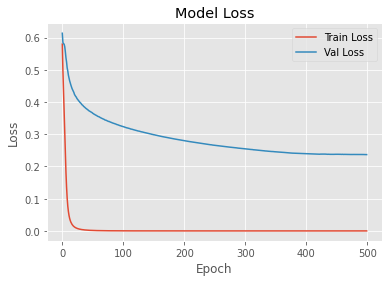

In [60]:
import matplotlib.pyplot as plt
model.save_weights(os.path.join(save_dir, "Models"))
plt.style.use('ggplot')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Val Loss'], loc='upper right')
plt.savefig(os.path.join(save_dir, 'LOSS_Text.png'))
plt.show()

In [62]:
tmp = model.predict_classes(x_dev)
precision, recall, fscore, _ = precision_recall_fscore_support(list(y_dev), tmp+1, average='macro')
print("\nprecision on dev set: %.4f" % precision)
print("\nrecall on dev set: %.4f" % recall)
print("\nfscore on dev set: %.4f" % fscore)


precision on dev set: 0.8677

recall on dev set: 0.8677

fscore on dev set: 0.8677


In [108]:
#model.load_weights(os.path.join(save_dir, "Models"))
#model.evaluate(x_dev, y_dev_keras)

60/60 [==============================] - 0s 52us/step


[0.23672221104303995, 0.9166666547457377]

In [223]:
correct_video = list()
for i in range(len(y_dev)):
    if (y_pred_dev_video[i]==y_dev[i]):
        correct_video.append(i)
        
correct_video1 = list()
for i in range(len(y_dev)):
    if (y_pred_dev_video1[i]==y_dev[i]):
        correct_video1.append(i)
        
correct_video2 = list()
for i in range(len(y_dev)):
    if (y_pred_dev_video2[i]==y_dev[i]):
        correct_video2.append(i)
        
correct_video3 = list()
for i in range(len(y_dev)):
    if (y_pred_dev_video3[i]==y_dev[i]):
        correct_video3.append(i)
        
correct_audio = list()
for i in range(len(y_dev)):
    if (y_pred_dev_audio[i]==y_dev[i]):
        correct_audio.append(i)
        
correct_audioE = list()
for i in range(len(y_dev)):
    if (y_pred_dev_audioE[i]==y_dev[i]):
        correct_audioE.append(i)
        
correct_text = list()
for i in range(len(y_dev)):
    if (y_pred_dev_text[i]==y_dev[i]):
        correct_text.append(i)

In [237]:
video_set = set(correct_video)
video_set1 = set(correct_video1)
video_set2 = set(correct_video2)
video_set3 = set(correct_video3)
audio_set = set(correct_audio)
audioE_set = set(correct_audioE)
text_set = set(correct_text)

universe = video_set | video_set1 | video_set2 | video_set3 | audio_set | audioE_set | text_set


def set_cover(universe, subsets):
    """Find a family of subsets that covers the universal set"""
    elements = set(e for s in subsets for e in s)
    
    if elements != universe:
        return None
    covered = set()
    cover = []
    # Greedily add the subsets with the most uncovered points
    while covered != elements:
        
        subset = max(subsets, key=lambda s: len(s - covered))
        cover.append(subset)
        covered |= subset
 
    return cover
 
tmp = set_cover(universe, [video_set, video_set1, video_set2, video_set3, audio_set, audioE_set, text_set])
sets_name = list()
for i in tmp:
    if (i == video_set):
        sets_name.append("ladmarks")
    elif (i == video_set1):
        sets_name.append("FAU")
    elif (i == video_set2):
        sets_name.append("Gaze")
    elif (i == video_set3):
        sets_name.append("Pose")
    elif (i == audio_set):
        sets_name.append("MFCC")
    elif (i == audioE_set):
        sets_name.append("eGeMAPS")
    elif (i == text_set):
        sets_name.append("Text")
print (sets_name)


['MFCC', 'ladmarks', 'FAU', 'Gaze']


In [305]:
video_set = set(correct_video)
video_set1 = set(correct_video1)
video_set2 = set(correct_video2)
video_set3 = set(correct_video3)
audio_set = set(correct_audio)
audioE_set = set(correct_audioE)
text_set = set(correct_text)

universe = video_set | video_set1 | video_set2 | video_set3 | audio_set | audioE_set | text_set
#generate the powerset and look for best combinations only (<4)
#brute force 
from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

powerset = list(powerset([video_set, video_set1, video_set2, video_set3, audio_set, audioE_set, text_set]))

for i in powerset:
    sets_name = list()
    for j in i:
        if (j == video_set):
            sets_name.append("ladmarks")
        elif (j == video_set1):
            sets_name.append("FAU")
        elif (j == video_set2):
            sets_name.append("Gaze")
        elif (j == video_set3):
            sets_name.append("Pose")
        elif (j == audio_set):
            sets_name.append("MFCC")
        elif (j == audioE_set):
            sets_name.append("eGeMAPS")
        elif (j == text_set):
            sets_name.append("Text")
    
    flat_list = [item for sublist in i for item in sublist]
    tmp = set(flat_list)
    if (tmp == universe):
        if (len(sets_name)<=4):
            print (sets_name)
    

['ladmarks', 'FAU', 'Gaze', 'Pose']
['ladmarks', 'FAU', 'Gaze', 'MFCC']
['ladmarks', 'FAU', 'Pose', 'MFCC']
['ladmarks', 'FAU', 'MFCC', 'Text']
['ladmarks', 'Gaze', 'MFCC', 'eGeMAPS']
['ladmarks', 'Gaze', 'MFCC', 'Text']
['ladmarks', 'Pose', 'MFCC', 'eGeMAPS']
['ladmarks', 'Pose', 'MFCC', 'Text']
['ladmarks', 'MFCC', 'eGeMAPS', 'Text']


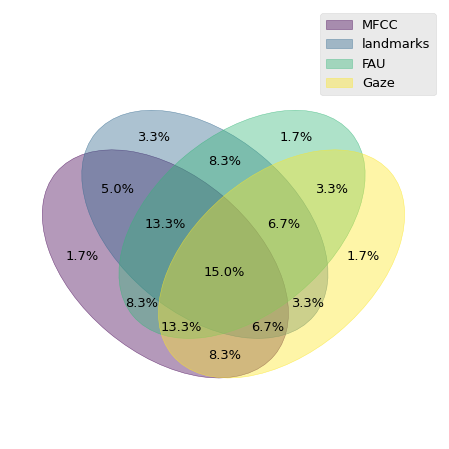

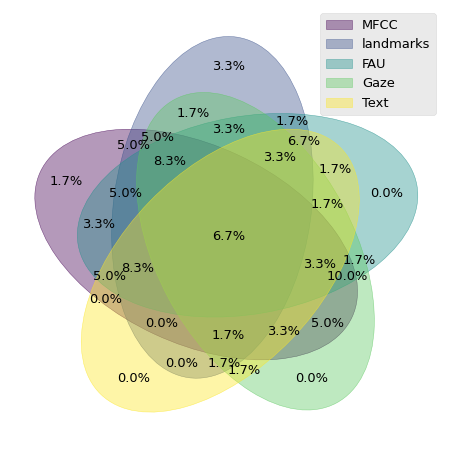

In [140]:
from venn import venn

musicians = {
    "MFCC": set(correct_audio),
    "landmarks": set(correct_video),
    "FAU": set(correct_video1),
    "Gaze": set(correct_video2)
    
}
venn(musicians,fmt="{percentage:.1f}%")


musicians = {
    
   "MFCC": set(correct_audio),
    "landmarks": set(correct_video),
    "FAU": set(correct_video1),
    "Gaze": set(correct_video2),
    "eGeMAPS": set(correct_audioE)
    
}

venn(musicians,fmt="{percentage:.1f}%")